## Práctica 6. Visualización de datos geoespaciales - Vector

Esta práctica está basada en el libro [Geographic Data Science with R: Visualizing and Analyzing Environmental Change](https://www.bookdown.org/mcwimberly/gdswr-book/).

Se implementarán visualizaciones sobre datos históricos de tornados en Oklahoma

#### 1. Importar datos

Los archivos que se cargarán están en formato .shp.  Para leerlos se utiliza la función `st_read()`.  Todos los archivos (.dbf, .prj, .shp, etc.) del formato shapefile deben estar en el mismo directorio de trabajo.  

1. Descargue el archivo TornadosOklahoma.zip y descomprímalo en su directorio de trabajo.
2. Lea los archivos con los contornos de los condados de Oklahoma, el origen de los tornados y sus trayectorias. *Observe que aunque al parecer se está leyendo un solo archivo en cada sentencia, en realidad, se están cargando datos de varios archivos con el mismo nombre.*

In [ ]:
install.packages("sf")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’




In [1]:
getwd()

[1] "/Users/miguela.monreal/CodigosVisInfo/Notebooks"

In [ ]:
library(sf)
library(units)
library(dplyr)
library(ggplot2)
okcounty <- st_read("TornadosOklahoma/ok_counties.shp", quiet = TRUE)
tpoint <- st_read("TornadosOklahoma/ok_tornado_point.shp", quiet = TRUE)
tpath <- st_read("TornadosOklahoma/ok_tornado_path.shp", quiet = TRUE)


# Respuesta pregunta uno

In [ ]:
glimpse(okcounty) #Su geometria es poligono
glimpse(tpoint) #Su geometria es punto
glimpse(tpath) #Su geometria es linea

## Respuesta pregunta 2


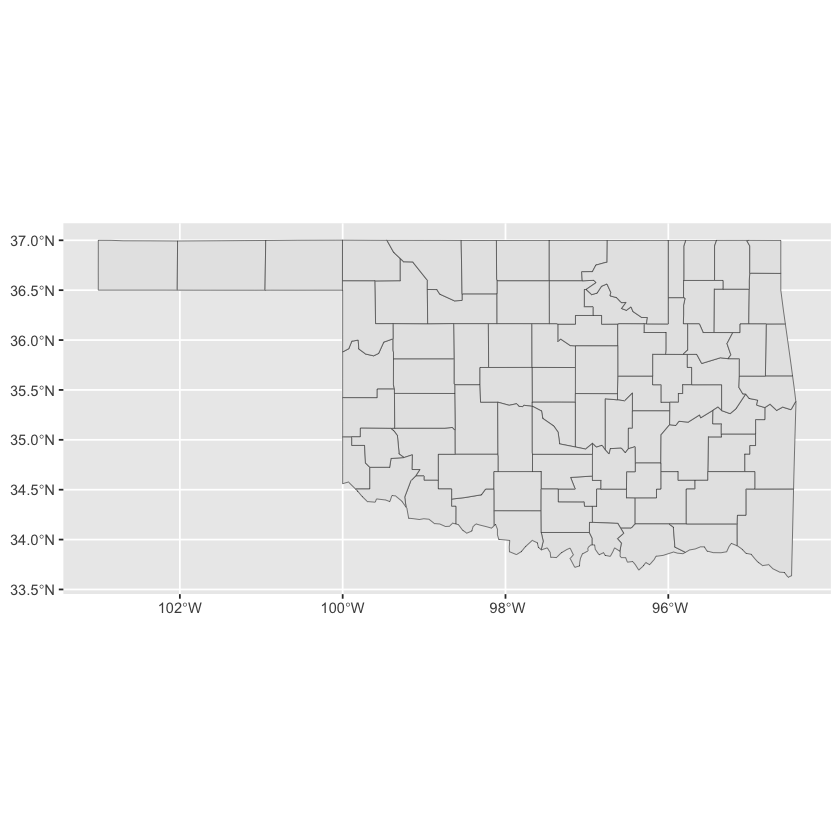

In [15]:
#Graficando okcounty

ggplot(okcounty) + geom_sf()


---

**PREGUNTA 1** ¿Qué clase de objeto son okcounty, tpoint y tpath?

¿Qué tipo de objetos geométrico tienen cada uno de esos archivos? (Ayuda: utilice la función `glimpse` o la función `head`),

---

---

**PREGUNTA 2** El dataframe okcounty tiene los polígonos de los condados del estado de Oklahoma. Grafíquelo sin rellenar los condados. Suba la gráfica obtenida

---


El dataset tornado tiene datos de 1950 a 2021, por lo que debemos filtrarlo si queremos graficar años específicos.  La columna `yr` indica el año en el que se presentó el tornado; la columna `om`  tiene un identificador único (UID) del tornado y  `date` la fecha en que apareció.  Vamos a crear un dataframe sólo con esas tres columnas para tornados entre 2016 y 2021:

In [11]:
tpoint_16_21 <- tpoint %>%
  filter(yr >= 2016 & yr <= 2021) %>%
  select(om, yr, date)

tpath_16_21 <- tpath %>%
  filter(yr >= 2016 & yr <= 2021) %>%
  select(om, yr, date)

In [12]:
st_crs(tpath_16_21)
#* El CRS que utiliza es NAD83
# Su datum es North American Datum 1983

Coordinate Reference System:
  User input: NAD83 
  wkt:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]

Como todos los archivos tienen el mismo sistema de coordenadas (CRS), los podemos combinar en un mismo mapa.

---
**PREGUNTA 3.** ¿Qué CRS y qué Datum tienen? Ayuda: Utilice la función `st_crs()`

---

Como cada capa tiene un dataset distinto, éste debe especificarse en cada llamada a *geom_sf()* como se muestra en el siguiente snippet, en el que graficamos los condados junto con los puntos en que apareció el tornado:

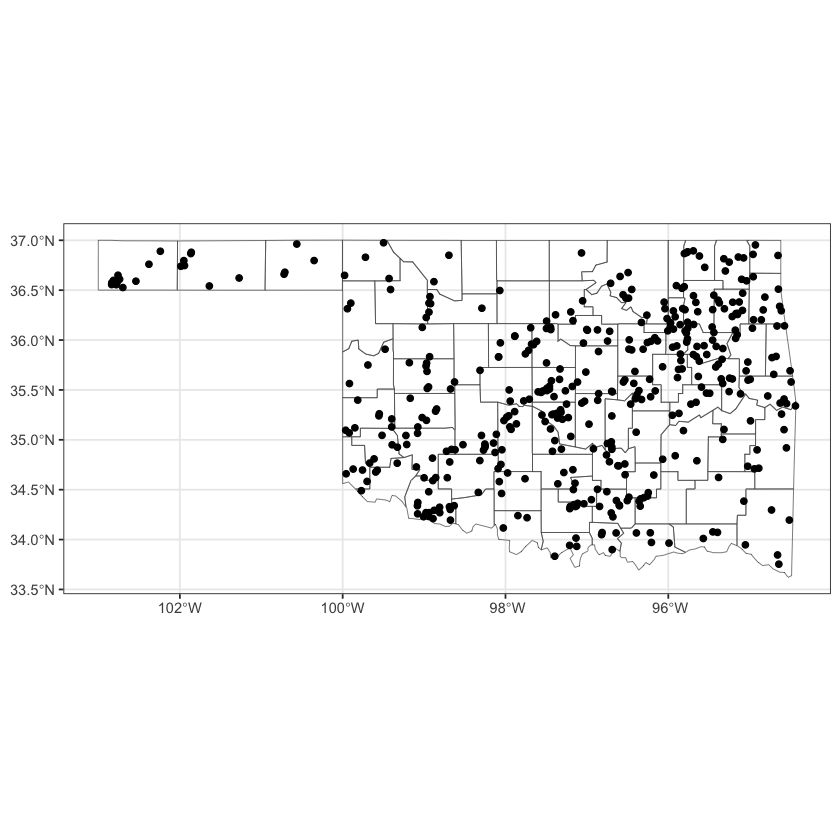

In [13]:
ggplot() +
  geom_sf(data = okcounty, fill = NA) +
  geom_sf(data = tpoint_16_21) +
  theme_bw()

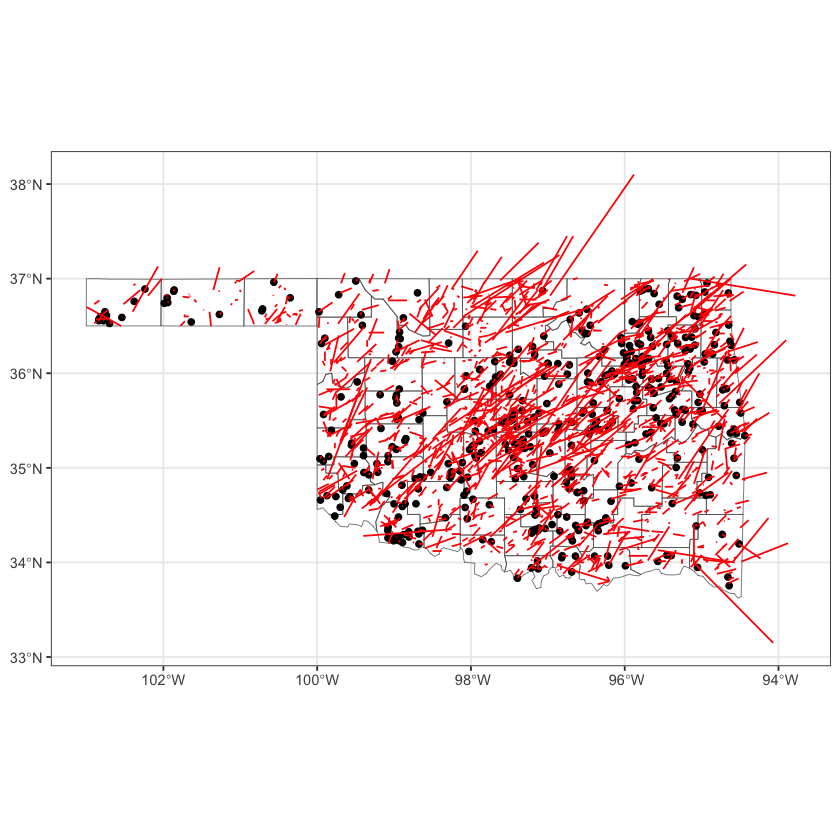

In [18]:
#Pregunta 5
ggplot() +
    geom_sf(data = okcounty, fill = NA) +
    geom_sf(data = tpoint_16_21) + geom_sf(data= tpath,color="red") +
    theme_bw()



---
**PREGUNTA 4**  Muestre la gráfica resultante

---

---
**PREGUNTA 5** Añada una capa con las trayectorias de los tornados.  Para distinguirlas, coloree las trayectorias en rojo.  Muestre la gráfica resultante

---

Podemos distinguir en qué año apareció cada tornado con distintos colores. Para ello, debemos hacer que el año sea una variable categórica.  En el siguiente snippet, la función `scale_color_discrete()` se utiliza para asignar los nombres adecuados a la leyenda:

In [ ]:
ggplot() +
  geom_sf(data = tpoint_16_21,
          aes(color = as.factor(yr))) + #! En esta parte volvemos al año como variable categorica
  geom_sf(data = okcounty, fill = NA) + 
  scale_color_discrete(name = "Year") + # Aqui asigamos los colores
  coord_sf(datum = NA) +
  theme_void()

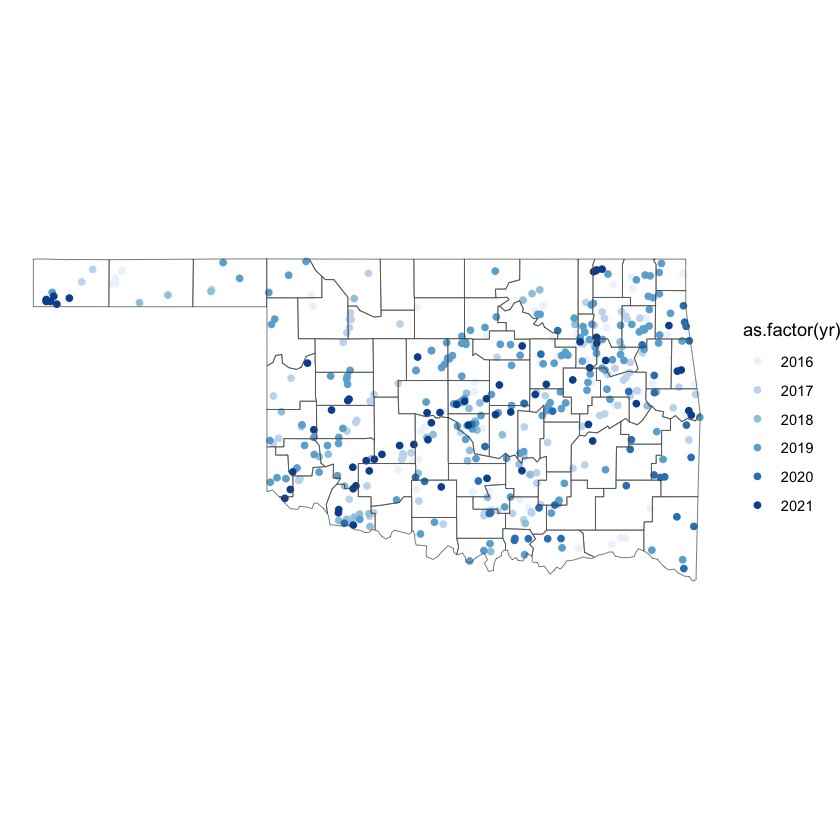

In [22]:
#Pregunta 6 
ggplot() +
    geom_sf(
        data = tpoint_16_21,
        aes(color = as.factor(yr))
    ) + # ! En esta parte volvemos al año como variable categorica
    geom_sf(data = okcounty, fill = NA) +
    scale_color_brewer(palette = 1) + #* Si es scale_color_brewer lo muestra en distinas tonalidades
    theme_void()

![](https://drive.google.com/uc?export=view&id=1IR-SlOMC9u5spAxgILoSejfvO5MRm4C6)


---
**PREGUNTA 6.** Muestre la figura anterior pero cambiando la paleta de colores: `scale_color_brewer(palette=1)`

---

#### 2. Operaciones sobre regiones geográficas

Como hemos mencionado, en los sistemas de información geográfica podemos realizar operaciones con capas que caen dentro de una misma región.  En este caso, calcularemos el número de tornados por condado y posteriormente desplegaremos esa información en el mapa con distintos canales visuales.

El primer paso es relacionar renglones de las dos tablas (en el siguiente ejemplo, la que tiene los polígonos y la de los tornados) con base en su ubicación espacial. Esto se hace con la función `st_join`.


In [23]:
countypnt <- st_join(tpoint_16_21, okcounty)

In [32]:
dim(okcounty) #* tiene 77 filas y 8 columnas
dim(tpoint_16_21) #* tiene 434 filas y 4 columnas
head(countypnt)


[1] 77  8

[1] 434   4

,om,yr,date,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,613662,2016,2016-03-23,40,001,01101788,0500000US40001,40001,Adair,06
2,613675,2016,2016-03-30,40,113,01101844,0500000US40113,40113,Osage,06
3,613676,2016,2016-03-30,40,105,01101840,0500000US40105,40105,Nowata,06
4,613677,2016,2016-03-30,40,131,01101853,0500000US40131,40131,Rogers,06
5,613678,2016,2016-03-30,40,035,01101805,0500000US40035,40035,Craig,06
6,613727,2016,2016-04-15,40,139,01101857,0500000US40139,40139,Texas,06


---
**PREGUNTA 7** ¿Cuántas observaciones y cuántas columnas tienen los dataframes okcounty, tpoint_16_21 y countypnt?

---


Como pudo notar, todavía tenemos un registro por tornado pero con información de okcounty que nos permitirá establecer relaciones entre los dos dataframes.

Pero antes, debemos preparar los datos, es decir, contar el número de tornados por condado. Para ello es necesario:

1. Convertir el objeto sf en un dataframe (función `st_drop_geometry()`)
2. Agrupar el nuevo dataframe por el identificador de condado (`GEOID`)
3. Calcular la suma, es decir, el número de ocurrencias por condado (función `summarize` con argumento `n()`)

In [29]:
countypnt <- st_drop_geometry(countypnt)
countysum <- countypnt %>%
  group_by(GEOID) %>%
  summarize(tcnt = n())

In [31]:
dim(countysum) #Tiene 75 filas y 2 columnas
head(countysum) #Dos condados no tuvieron tornados

[1] 75  2

GEOID,tcnt
<chr>,<int>
40001,6
40005,3
40007,4
40009,8
40011,1
40013,4


---
**PREGUNTA 8.** ¿Qué dimensiones tiene `countysum`? Al parecer, ¿Cuántos condados no tuvieron tornados en los años analizados?

---

Ahora estamos en posibilidad de unir (en el sentido de una base de datos) los dos dataframes. Como hay menos condados en countypnt que en okcounty, haremos un left_joint y nos aseguramos que los 'NA' de okcounty sean remplazados por '0' (hubo cero tornados en esos condados).   

La función `st_area()` calcula el área de un polígono. La utilizaremos con `mutate` para calcular el área de todos los condados y a partir de ella, podemos calcular la densidad de tornados por condado:

In [33]:
countymap <- okcounty %>%
  left_join(countysum, by = "GEOID") %>%
  replace(is.na(.), 0) %>%
  mutate(area = st_area(okcounty),
         tdens = 10^6 * 10^3 * tcnt / area) %>%
  drop_units()

In [42]:
dim(countymap) #Tiene 77 filas y 11 columnas
print(head(countymap)) #Tiene las columnas adicionales de area y tdens, dos condados no tuvieron tornados



[1] 77 11

Simple feature collection with 6 features and 10 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -103.0025 ymin: 34.68074 xmax: -94.92767 ymax: 37.0001
Geodetic CRS:  NAD83
  STATEFP COUNTYFP COUNTYNS       AFFGEOID GEOID     NAME LSAD tcnt
1      40      077 01101826 0500000US40077 40077  Latimer   06    1
2      40      025 01101800 0500000US40025 40025 Cimarron   06   12
3      40      011 01101793 0500000US40011 40011   Blaine   06    1
4      40      107 01101841 0500000US40107 40107 Okfuskee   06   10
5      40      105 01101840 0500000US40105 40105   Nowata   06    6
6      40      153 01101864 0500000US40153 40153 Woodward   06    2
                        geometry       area     tdens
1 POLYGON ((-95.50766 35.0292... 1890663261 0.5289149
2 POLYGON ((-103.0025 36.6751... 4766283042 2.5176851
3 POLYGON ((-98.6369 36.16489... 2427121029 0.4120108
4 POLYGON ((-96.62486 35.4627... 1657249513 6.0340944
5 POLYGON ((-95.80982 36.9419... 1503893122 3.9896452
6 POLY

---
**PREGUNTA 9.** ¿Cuántos renglones y columnas tiene countymap?  ¿Qué columnas adicionales tiene con relación a okcounty?

---

---

**PREGUNTA 10.** ¿Qué condados no tuvieron tornados en el periodo analizado?

---

Si deseamos guardar nuestro dataframe en formato GeoJSON, lo podemos hacer con la función `st_write()`. Para asegurar que se utiliza la última especificación, se añade el argumento que se muestra:

In [43]:
st_write(countymap, "oktornado.geojson",
           layer_options = "RFC7946 = YES")

Writing layer `oktornado' to data source `oktornado.geojson' using driver `GeoJSON'
options:        RFC7946 = YES 
Writing 77 features with 10 fields and geometry type Polygon.


#### 3. Visualización de datos

Ya tenemos todo lo necesario para crear nuestras visualizaciones. Hagamos la primera como un **mapa de coropletas** con la densidad por condado que calculamos atrás

---

**PREGUNTA 11** Haga lo necesario para desplegar el mapa de coropletas.  Muestre la gráfica resultante

---

Como ya sabemos, si lo que deseamos es mostrar el número de tornados por condado en vez de la densidad, es más conveniente utilizar un **mapa de símbolos**  utilizando el canal visual de tamaño para representar variaciones de cantidad.

Entonces, colocaremos un punto en cada condado cuyo tamaño será proporcional al número de tornados, pero ese punto debe estar en el centro del condado. Para ubicar el centro, utilizaremos la función `st_centroid()`.

Warning message:
“st_centroid assumes attributes are constant over geometries”


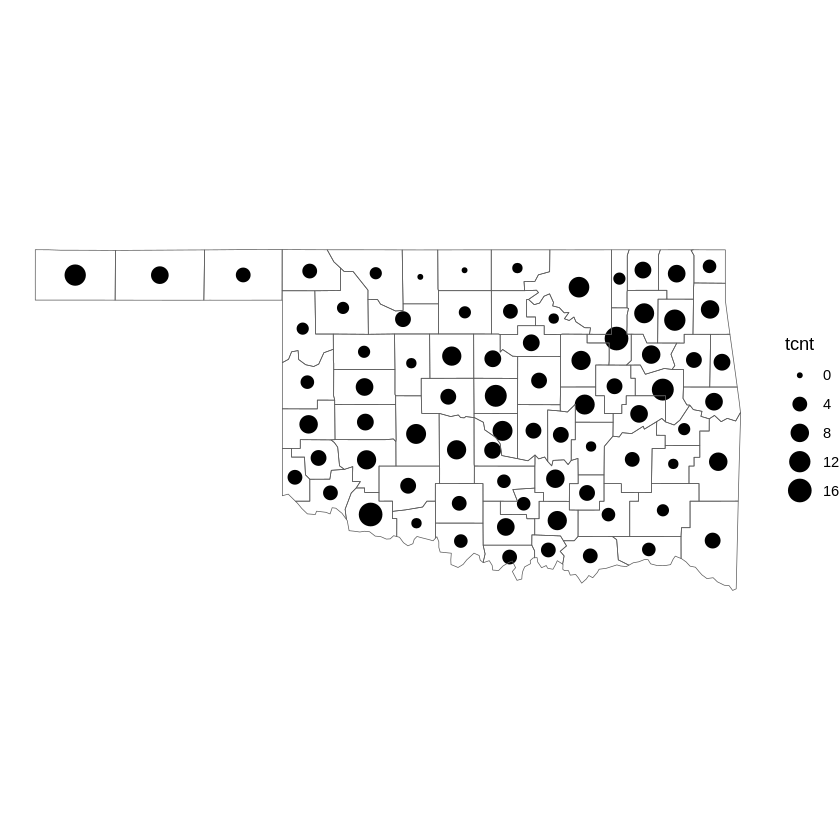

In [ ]:
okcntrd = st_centroid(countymap)

ggplot() +
  geom_sf(data = okcntrd, aes(size = tcnt)) +
  geom_sf(data = okcounty, fill = NA) +
  theme_void()

---
**PREGUNTA 12** Haga el mapa anterior con el color de los condados en azul claro y el de los puntos en azul. Puede ser que deba invertir las capas o añadir un porcentaje de transparencia al relleno del condado

---

---

**PREGUNTA 13**  Regresemos a la visualización de la densidad de los tornados. Haga un mapa de coropletas con una paleta cromática de verdes (Greens)  con ayuda de la función `scale_fill_distiller`.  Para la leyenda, ponga como título "Tornados/1000 km^2". Haga un mapa de coropletas con una paleta cromática de verdes (Greens)  con ayuda de la función `scale_fill_distiller`.

---

Como sabemos, es imposible distinguir una gradación continua de tonalidades y, de hecho, muy difícil distinguir más de 8 o 10 tonalidades.  Por ello, cuando se desea representar datos cuantitativos con una escala de colores, es conveniente primero agruparlos en un número pequeño de clases (de 3 a 6) y asignar colores a esas clases.

Podemos hacer esto en R añadiendo una columna a nuestro dataset con la función `mutate()`, indicando cortes de la variable continua con la función `cut()`:

In [ ]:
countymap <- countymap %>%
  mutate(tdens_c1 = cut(tdens,breaks =  4,include.lowest = T))


Como ahora tenemos una columna con una variable discreta (un factor), utilizamos la función `scale_fill_brewer()` en vez de `scale_fill_distiller()`.

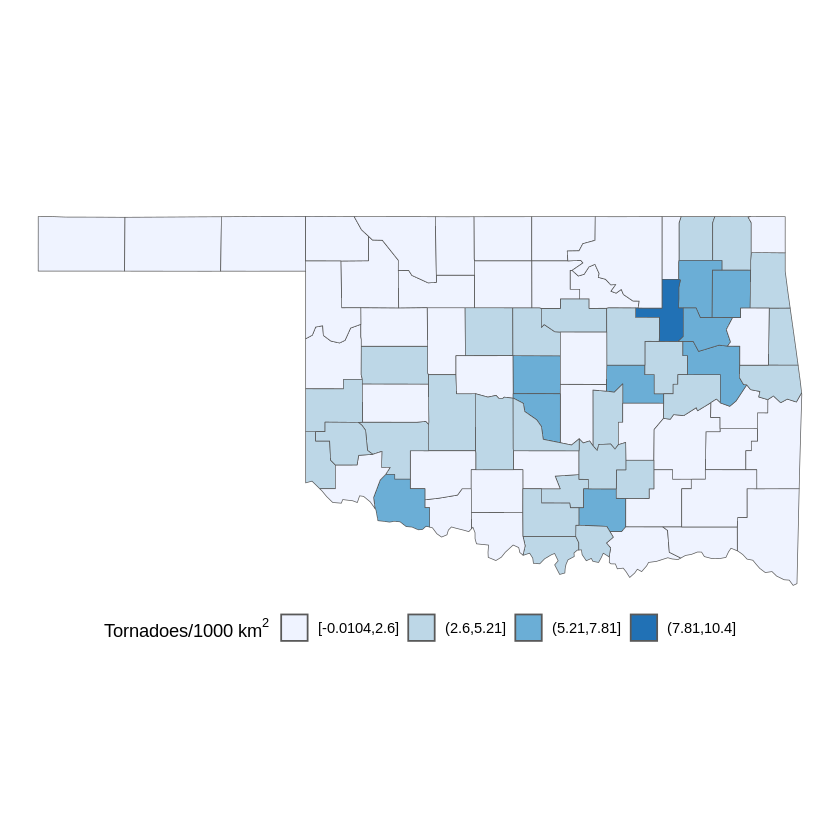

In [ ]:
ggplot(data = countymap) +
  geom_sf(aes(fill = tdens_c1)) +
  scale_fill_brewer(name = expression("Tornadoes/1000 km"^2),
                    palette = "Blues") +
  theme_void() +
  theme(legend.position = "bottom")

---
**PREGUNTA 14.** Repita la figura anterior pero con seis cortes. Muestre la figura resultante

---

Podemos hacer lo mismo en mapas de símbolos para acotar el número de tamaños diferentes que pueden tener, por ejemplo, nuestros puntos.

---

**PREGUNTA 15.** Haga un mapa de símbolos en el que el número de tornados por condado puede caer en uno de cinco tamaños de punto.